In [1]:
import sys

In [2]:
sys.path.append('/home/bh774267/.local/lib/python3.11/site-packages')

In [3]:
import requests
import pandas as pd
from io import StringIO

In [4]:
import re

In [23]:
!pip install --upgrade --user certifi

In [24]:
!pip install --user biopython

  Using cached biopython-1.86-cp311-cp311-manylinux2014_x86_64.manylinux_2_17_x86_64.manylinux_2_28_x86_64.whl.metadata (13 kB)
Using cached biopython-1.86-cp311-cp311-manylinux2014_x86_64.manylinux_2_17_x86_64.manylinux_2_28_x86_64.whl (3.2 MB)


In [25]:
!pip install --user biopython-dssp

ERROR: Could not find a version that satisfies the requirement biopython-dssp (from versions: none)
ERROR: No matching distribution found for biopython-dssp


In [26]:
import certifi
print(certifi.where())

/cvmfs/jupyter.hpc.rwth.de/clients/python311-c23/lib/python3.11/site-packages/certifi/cacert.pem


In [5]:

# SCOPe release version (e.g., 2.08 or latest)
SCOPE_VERSION = "2.08"

# URLs for SCOPe classification and description files
#base_url = f"https://scop.berkeley.edu/downloads/ver={SCOPE_VERSION}/"
cla_url = f"https://scop.berkeley.edu/downloads/parse/dir.cla.scope.{SCOPE_VERSION}-stable.txt"
des_url = f"https://scop.berkeley.edu/downloads/parse/dir.des.scope.{SCOPE_VERSION}-stable.txt"

#https://scop.berkeley.edu/downloads/parse/dir.cla.scope.2.08-stable.txt
#https://scop.berkeley.edu/downloads/parse/dir.des.scope.2.08-stable.txt
# Download classification file
print("Downloading SCOPe classification file...")
cla_text = requests.get(cla_url, verify=False).text

# Parse classification lines
cla_rows = []
for line in cla_text.splitlines():
    if line.startswith("#") or not line.strip():  # skip comments
        continue
    parts = line.strip().split()
    # Example line: d1uxya_ 1uxy A: - a.1.1.1
    if len(parts) < 5:
        # skip malformed or short lines
        continue
    domain_id = parts[0]
    pdb_id = parts[1][:4]
    chain = parts[2]
    classification = parts[3]
    
    pattern = r'^([a-z])'
    cla_rows.append((domain_id, pdb_id, chain, classification))

df_cla = pd.DataFrame(cla_rows, columns=["domain", "pdb_id", "chain", "fold_id"])
df_cla['main_class'] = df_cla['fold_id'].str.extract(pattern, expand=False)

print(f"Parsed {len(df_cla)} SCOPe domains")
print(df_cla.head())


/cvmfs/jupyter.hpc.rwth.de/clients/python311-c23/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'scop.berkeley.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Parsed 344851 SCOPe domains
    domain pdb_id chain  fold_id main_class
0  d1ux8a_   1ux8    A:  a.1.1.1          a
1  d1dlwa_   1dlw    A:  a.1.1.1          a
2  d1uvya_   1uvy    A:  a.1.1.1          a
3  d1dlya_   1dly    A:  a.1.1.1          a
4  d1uvxa_   1uvx    A:  a.1.1.1          a


In [6]:
train_labels = df_cla['main_class']
class_counts = train_labels.value_counts().sort_index()

# Convert counts to a NumPy array for easy calculation
counts = class_counts.values
print(counts)

[44351 76704 84010 76035  7353  7018  7138  2715  2866   978   316 35367]


In [24]:
df_cla_subset = df_cla.sample(n=2000, random_state=42)

#df_cla_subset.pdb_id.nunique()
#df_cla_subset.count()
"""
# 1. Get the counts for each unique string label
class_counts_series = df_cla_subset['main_class'].value_counts()

# 2. Convert the Series to a DataFrame for clear formatting
counts_df = class_counts_series.reset_index()

# 3. Rename columns for clarity (the column holding the labels is typically named 'index' or the column name)
counts_df.columns = ['Class_Label', 'Sample_Count']

# 4. Sort the DataFrame by Sample_Count in ascending order to find the rarest classes first
rarest_classes_info = counts_df.sort_values(by='Sample_Count', ascending=True)

print("### Classes Sorted from Rarest to Most Common (First 5 are the Rarest) ###")
print(rarest_classes_info.head())
"""


rare_classes_to_drop = ['k', 'j', 'i', 'h']
df_filtered = df_cla_subset[~df_cla_subset['main_class'].isin(rare_classes_to_drop)].copy()

# 1. Get the unique remaining original labels (e.g., [0, 1, 2, 3, 4, 5, 6, 11])
unique_classes = sorted(df_filtered['main_class'].unique()) 
print(unique_classes)
print("N unique classes after filtering:", df_filtered['main_class'].nunique())

# 2. Assign a new, zero-based index to each remaining original label
class_map = {old_label: new_label for new_label, old_label in enumerate(unique_classes)}

# 3. Apply the map to the DataFrame
df_filtered['mapped_class'] = df_filtered['main_class'].map(class_map)

df_filtered['mapped_class'].nunique()

#train_labels = df_filtered['main_class']
#class_counts = train_labels.value_counts().sort_index()

# Convert counts to a NumPy array for easy calculation
#counts = class_counts.values
#print(counts)



['a', 'b', 'c', 'd', 'e', 'f', 'g', 'l']
N unique classes after filtering: 8


8

In [101]:
class_value = df_cla_subset['main_class']!=7]
print(class_value)

SyntaxError: unmatched ']' (3102740246.py, line 1)

In [102]:
SCOP_TO_INT = {
    'a': 0, 'b': 1, 'c': 2, 'd': 3,
    'e': 4, 'f': 5, 'g': 6, 'h': 7,
    'i': 8,'j': 9, 'k': 10, 'l': 11
}

INT_TO_CLASS_NAME = {
    0: 'All alpha proteins',
    1: 'All beta proteins',
    2: 'Alpha/beta proteins',
    3: 'Alpha+beta proteins',
    4: 'Small proteins',
    5: 'Multi-domain proteins',
    6: 'Membrane proteins',
    7: 'Peptides/Coiled coils',
    8: 'Artificially generated peptides',
    9: 'Low resolution structures' ,
    10: 'Proteins that have not been classified',
    11: 'Others (Peptides/fragments)'
}

In [25]:
import os
import numpy as np
import pandas as pd
from Bio.PDB import PDBParser
from Bio.PDB import PDBList

pdbl = PDBList()

def ensure_dir(directory):
    """Create directory if it doesn’t exist."""
    if not os.path.exists(directory):
        os.makedirs(directory, exist_ok=True)
        #print(f"[INFO] Created directory: {directory}")


def get_pdb_path(pdb_id, pdb_dir, max_retries=3):
    if max_retries < 1:
        max_retries = 3
    
    #print(f"[DEBUG] {pdb_id}: max_retries = {max_retries}")
    ensure_dir(pdb_dir)

    pdb_id = pdb_id.lower()
    
    pdb_path = os.path.join(pdb_dir, f"{pdb_id}.pdb")

    if os.path.exists(pdb_path) and os.path.getsize(pdb_path) > 1000:
        return pdb_path
    url = f"https://files.rcsb.org/download/{pdb_id}.pdb"
    for attempt in range(1, max_retries + 1):
        try:
            response = requests.get(url, timeout=15)
            if response.status_code == 200 and len(response.text) > 1000:
                with open(pdb_path, "w") as f:
                    f.write(response.text)
                #print(f"[INFO] Downloaded {pdb_id} (attempt {attempt})")
                return pdb_path
            elif response.status_code == 404:
                print(f"[WARN] {pdb_id} not found (HTTP 404)")
                return None
            else:
                print(f"[WARN] Attempt {attempt}: {pdb_id} failed (HTTP {response.status_code})")
        except Exception as e:
            print(f"[ERROR] {pdb_id} attempt {attempt} failed: {e}")
        
        # Wait before retrying
        time.sleep(2)

    # Only runs if all attempts failed
    print(f"[ERROR] Could not download {pdb_id} after {max_retries} attempts.")
    return None

In [26]:

def extract_ca_coordinates(pdb_path, chain_id):
    parser = PDBParser(QUIET=True)
    structure = parser.get_structure("protein", pdb_path)
    
    try:
        chain = structure[0][chain_id]
    except KeyError:
        print(f"[WARN] Chain {chain_id} not found in {os.path.basename(pdb_path)}")
        return None, None
    
    coords, res_ids = [], []
    for residue in chain:
        if "CA" in residue:
            coords.append(residue["CA"].get_coord())
            res_ids.append(residue.get_id()[1])
    
    if not coords:
        print(f"[WARN] No Cα atoms found in {os.path.basename(pdb_path)} chain {chain_id}")
        return None, None
    
    return res_ids, np.array(coords)

def parse_all_pdbs(df, pdb_dir):
    results = []
    ensure_dir(pdb_dir)
    count = 0
    
    for i, row in df.iterrows():
        pdb_id = row['pdb_id'].upper()
        chain_id = row['chain'].strip().split(':')[0]
        fold_id = row['fold_id']
        domain = row['domain']
        main_class = row['main_class']
        pdb_path = get_pdb_path(pdb_id, pdb_dir,count)
        if pdb_path is None:
            continue
        print(f"Extracting {pdb_id} chain {chain_id}")
        res_ids, coords = extract_ca_coordinates(pdb_path, chain_id)
        print(" → Residues:", len(res_ids) if res_ids else 0)
        if coords is None:
            continue
            
        results.append({
            'pdb_id': pdb_id,
            'chain': chain_id,
            'fold_id': fold_id,
            'domain': domain,
            'main_class' : main_class,
            'n_residues': len(res_ids),
            'res_ids': res_ids,
            'ca_coords': coords
        })
    
    return pd.DataFrame(results)


In [27]:
pdb_dir = "pdb_files"

parsed_df = parse_all_pdbs(df_filtered, pdb_dir)

Extracting 1GYT chain D
 → Residues: 503
Extracting 3QUC chain A
 → Residues: 225
Extracting 6B7F chain A
 → Residues: 159
Extracting 5EP8 chain B
 → Residues: 433
Extracting 1B47 chain B
 → Residues: 305
Extracting 4QZ6 chain C
 → Residues: 240
Extracting 4PJC chain G
 → Residues: 197
Extracting 2QZ0 chain A
 → Residues: 224
Extracting 4MVW chain B
 → Residues: 536
Extracting 6IJN chain A
 → Residues: 341
Extracting 2F6D chain A
 → Residues: 492
Extracting 4N99 chain B
 → Residues: 366
Extracting 6VDR chain A
 → Residues: 137
Extracting 1CBK chain A
 → Residues: 160
Extracting 1XNR chain J
 → Residues: 98
Extracting 6X0C chain A
 → Residues: 253
Extracting 3II0 chain D
 → Residues: 407
Extracting 7N7Z chain A
 → Residues: 396
Extracting 6BVA chain A
 → Residues: 86
Extracting 4O7U chain D
 → Residues: 315
Extracting 8ATC chain A
 → Residues: 310
Extracting 1ZKN chain A
 → Residues: 334
Extracting 1EZV chain Y
 → Residues: 107
Extracting 5K1V chain B
 → Residues: 849
Extracting 1Q0G ch

In [28]:
parsed_df.columns

Index(['pdb_id', 'chain', 'fold_id', 'domain', 'main_class', 'n_residues',
       'res_ids', 'ca_coords'],
      dtype='object')

In [29]:
parsed_df.head(10)

pdb_id chain    fold_id   domain main_class  n_residues  \
0   1GYT     D   c.50.1.1  d1gytd1          c         503   
1   3QUC     A    l.1.1.1  d3quca2          l         225   
2   6B7F     A   c.26.1.3  d6b7fa1          c         159   
3   5EP8     B   a.46.2.0  d5ep8b1          a         433   
4   1B47     B   d.93.1.1  d1b47b3          d         305   
5   4QZ6     C  d.153.1.0  d4qz6c1          d         240   
6   4PJC     G    b.1.1.0  d4pjcg1          b         197   
7   2QZ0     A   d.22.1.1  d2qz0a_          d         224   
8   4MVW     B   a.27.1.0  d4mvwb2          a         536   
9   6IJN     A    l.1.1.1  d6ijna2          l         341   

                                             res_ids  \
0  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
1  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...   
2  [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1...   
3  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
4  [47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 5...   
5  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
6  [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1...   
7  [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, ...   
8  [-4, -3, -2, -1, 0, 237, 238, 239, 240, 241, 2...   
9  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...   

                                           ca_coords  
0  [[43.051, 72.512, -36.076], [43.656, 75.149, -...  
1  [[-10.775, 17.556, -22.427], [-13.968, 19.307,...  
2  [[32.492, 124.4, 199.541], [32.398, 121.944, 1...  
3  [[-13.57, 23.96, 40.081], [-11.01, 26.79, 40.2...  
4  [[10.97, 33.014, 61.748], [13.983, 33.508, 59....  
5  [[34.223, -95.937, 33.664], [33.861, -92.274, ...  
6  [[-36.69, 17.675, 197.504], [-33.073, 16.414, ...  
7  [[-0.553, 22.985, 15.575], [0.782, 20.309, 13....  
8  [[-12.849, 13.549, -20.477], [-11.962, 15.363,...  
9  [[35.155, 11.067, 1.827], [32.14, 11.011, -0.4...

In [30]:
parsed_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1962 entries, 0 to 1961
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   pdb_id      1962 non-null   object
 1   chain       1962 non-null   object
 2   fold_id     1962 non-null   object
 3   domain      1962 non-null   object
 4   main_class  1962 non-null   object
 5   n_residues  1962 non-null   int64 
 6   res_ids     1962 non-null   object
 7   ca_coords   1962 non-null   object
dtypes: int64(1), object(7)
memory usage: 122.8+ KB


In [31]:
print("Label min:", parsed_df['main_class'].min())
print("Label max:", parsed_df['main_class'].max())
print("Number of unique labels:", parsed_df['main_class'].nunique())
print("Top 30 chains",parsed_df['main_class'].head(30))

Label min: a
Label max: l
Number of unique labels: 8
Top 30 chains 0     c
1     l
2     c
3     a
4     d
5     d
6     b
7     d
8     a
9     l
10    a
11    d
12    a
13    d
14    d
15    c
16    l
17    c
18    d
19    d
20    c
21    a
22    b
23    a
24    a
25    a
26    c
27    d
28    c
29    b
Name: main_class, dtype: object


In [32]:
parsed_df.describe()

n_residues
count  1962.000000
mean    279.262997
std     185.552015
min       7.000000
25%     155.000000
50%     238.000000
75%     344.000000
max    1486.000000

In [16]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # 3D plotting tools

# Pick one structure to visualize
i = 1000  # change index to view another one
coords = parsed_df.loc[i, 'ca_coords']
pdb_id = parsed_df.loc[i, 'pdb_id']
chain = parsed_df.loc[i, 'chain']

fig = plt.figure(figsize=(7, 6))
ax = fig.add_subplot(111, projection='3d')

# Plot the CA trace (connected by lines)
ax.plot(coords[:, 0], coords[:, 1], coords[:, 2], '-o', markersize=3, linewidth=1.2)

ax.set_title(f'Cα trace for {pdb_id} chain {chain}', fontsize=14)
ax.set_xlabel('X (Å)')
ax.set_ylabel('Y (Å)')
ax.set_zlabel('Z (Å)')
plt.show()


KeyError: 1000

In [28]:
!pip install --user py3Dmol

In [16]:
import py3Dmol

pdb_id = parsed_df.loc[1000, 'pdb_id']
pdb_path = f"pdb_files/{pdb_id.lower()}.pdb"

with open(pdb_path) as f:
    pdb_data = f.read()

viewer = py3Dmol.view(width=600, height=400)
viewer.addModel(pdb_data, 'pdb')
viewer.setStyle({'cartoon': {'color': 'spectrum'}})
viewer.zoomTo()
viewer.show()


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [22]:
"""
import numpy as np

def voxelize_ca_old(coords, grid_size=32, padding=5.0):
    """
    Convert Cα coordinates to a 3D voxel grid.

    coords: np.array of shape (N,3)
    grid_size: number of voxels per axis
    padding: extra space around protein (Å)
    
    Returns: 3D numpy array (grid_size, grid_size, grid_size)
    """
    coords = np.array(coords)
    
    # Translate protein to origin
    min_coords = coords.min(axis=0) - padding
    max_coords = coords.max(axis=0) + padding
    coords = coords - min_coords
    
    # Scale to grid
    scale = (grid_size - 1) / (max_coords - min_coords).max()
    coords_scaled = (coords * scale).astype(int)
    
    # Initialize empty grid
    grid = np.zeros((grid_size, grid_size, grid_size), dtype=np.float32)
    
    # Set voxels for Cα positions
    for x, y, z in coords_scaled:
        grid[x, y, z] = 1.0
    
    return grid
    """

In [33]:

import numpy as np
def voxelize_ca(coords, grid_size, sigma=2.0):
    grid = np.zeros((grid_size, grid_size, grid_size), dtype=np.float32)
    resolution=2.0
    # Normalize coordinates to [0, grid_size-1]
    #coords = np.array(coords)
    #min_coords = coords.min(axis=0)
    #max_coords = coords.max(axis=0)
    #coords_scaled = (coords - min_coords) / (max_coords - min_coords + 1e-6) * (grid_size - 1)
    if not isinstance(coords, torch.Tensor):
        coords = torch.tensor(coords, dtype=torch.float32)
    
    #coords_centered = coords - coords.mean(axis=0)
    coords_centered = coords - torch.mean(coords, dim=0)
    grid_center_idx = grid_size / 2.0
    
    coords_mapped = (coords_centered / resolution) + grid_center_idx
    for x, y, z in coords_mapped:
        # Round to nearest integer index
        #xi, yi, zi = int(round(x)), int(round(y)), int(round(z))
        xi = int(torch.round(x).item())
        yi = int(torch.round(y).item())
        zi = int(torch.round(z).item())
        
        # Spread points with a small Gaussian kernel
        for dx in range(-1, 2):
            for dy in range(-1, 2):
                for dz in range(-1, 2):
                    x_idx = xi + dx
                    y_idx = yi + dy
                    z_idx = zi + dz
                    
                    # Boundary Check: Only fill voxels within the grid limits [0, grid_size-1]
                    if 0 <= x_idx < grid_size and 0 <= y_idx < grid_size and 0 <= z_idx < grid_size:
                        # Simple distance-based weighting (Gaussian-like)
                        weight = np.exp(-(dx**2 + dy**2 + dz**2) / (2 * sigma**2))
                        grid[x_idx, y_idx, z_idx] += weight
                        
    # 4. Normalize to [0,1]
    # Handle the case where the grid might be entirely empty (unlikely with Cα but good practice)
    if grid.max() > 0:
        grid = grid / grid.max()
        
    return grid


In [34]:

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader

# Encode fold IDs as integers
le = LabelEncoder()
parsed_df['fold_label'] = le.fit_transform(parsed_df['main_class'])

fold_counts = parsed_df['fold_label'].value_counts()
parsed_df_clean = parsed_df[parsed_df['fold_label'].isin(fold_counts[fold_counts > 1].index)]

class ProteinDataset(Dataset):
    def __init__(self, df, grid_size=48):
        self.df = df
        self.grid_size = grid_size

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        coords = self.df.iloc[idx]['ca_coords']
        X = voxelize_ca(coords, grid_size=self.grid_size)
        y = self.df.iloc[idx]['fold_label']
        return torch.tensor(X, dtype=torch.float32).unsqueeze(0), torch.tensor(y, dtype=torch.long)

train_df1, test_df1 = train_test_split(parsed_df_clean, test_size=0.3, stratify= parsed_df_clean['fold_label'], random_state=42, shuffle=True)

train_dataset1 = ProteinDataset(train_df1)
test_dataset1 = ProteinDataset(test_df1)

train_loader1 = DataLoader(train_dataset1, batch_size=8, shuffle=True)
test_loader1 = DataLoader(test_dataset1, batch_size=8, shuffle=False)


In [35]:
print("Label min:", parsed_df['fold_label'].min())
print("Label max:", parsed_df['fold_label'].max())
print("Number of unique labels:", parsed_df['fold_label'].nunique())
"""
for i in range(5):
    features, label = train_dataset[i]
    print(f"Sample {i}:")
    print("  Features shape:", features.shape)
    print("  Label:", label.item())
"""
# 1. Get the counts of each class label (0 to 11) in the training data
train_labels = train_df1['fold_label']
class_counts = train_labels.value_counts().sort_index()

# Convert counts to a NumPy array for easy calculation
counts = class_counts.values
print(counts)

Label min: 0
Label max: 7
Number of unique labels: 8
[166 307 333 330  38  27  29 143]


In [36]:
import pennylane as qml
import os
from pennylane import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
from torch.func import vmap

In [41]:
class VariationalEncoder(nn.Module):
    def __init__(self, latent_dims=8):
        super(VariationalEncoder, self).__init__()
        self.linear1 = nn.Linear(110592, 512)
        self.linear2 = nn.Linear(512, latent_dims)
        self.linear3 = nn.Linear(512, latent_dims)

        self.N = torch.distributions.Normal(0, 1)
        self.N.loc = self.N.loc.cuda() # hack to get sampling on the GPU
        self.N.scale = self.N.scale.cuda()
        self.kl = 0

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        mu =  self.linear2(x)
        sigma = torch.exp(self.linear3(x))
        z = mu + sigma*self.N.sample(mu.shape)
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
        return z

In [42]:
class Decoder(nn.Module):
    def __init__(self, latent_dims=8):
        super(Decoder, self).__init__()
        self.linear1 = nn.Linear(latent_dims, 512)
        self.linear2 = nn.Linear(512, 110592)

    def forward(self, z):
        z = F.relu(self.linear1(z))
        z = torch.sigmoid(self.linear2(z))
        return z.reshape((-1, 1, 48, 48, 48))

In [23]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = VariationalEncoder(latent_dims)
        self.decoder = Decoder(latent_dims)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

In [120]:
def train(autoencoder, data, epochs=20):
    opt = torch.optim.Adam(autoencoder.parameters(),lr=1e-4)
    count = 0
    for epoch in range(epochs):
        print("We have just started the first for loop")
        for x, y in data:
            #print("We are in the 2nd loop")
            x = x.to(device) # GPU
            opt.zero_grad()
            x_hat = autoencoder(x)
            loss = ((x - x_hat)**2).sum() + autoencoder.encoder.kl
            loss.backward()
            opt.step()
        count +=1
        print("Epoch ran",count)
    return autoencoder

In [121]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [122]:
vae = VariationalAutoencoder(latent_dims=16).to(device) # GPU
vae = train(vae, train_loader1)

We have just started the first for loop
Epoch ran 1
We have just started the first for loop
Epoch ran 2
We have just started the first for loop
Epoch ran 3
We have just started the first for loop
Epoch ran 4
We have just started the first for loop
Epoch ran 5
We have just started the first for loop
Epoch ran 6
We have just started the first for loop
Epoch ran 7
We have just started the first for loop
Epoch ran 8
We have just started the first for loop
Epoch ran 9
We have just started the first for loop
Epoch ran 10
We have just started the first for loop
Epoch ran 11
We have just started the first for loop
Epoch ran 12
We have just started the first for loop
Epoch ran 13
We have just started the first for loop
Epoch ran 14
We have just started the first for loop
Epoch ran 15
We have just started the first for loop
Epoch ran 16
We have just started the first for loop
Epoch ran 17
We have just started the first for loop
Epoch ran 18
We have just started the first for loop
Epoch ran 19
We

In [123]:
def plot_latent(autoencoder, data, num_batches=100):
    for i, (x, y) in enumerate(data):
        z = autoencoder.encoder(x.to(device))
        z = z.to('cpu').detach().numpy()
        plt.scatter(z[:, 0], z[:, 1], c=y, cmap='tab10')
        if i > num_batches:
            plt.colorbar()
            break

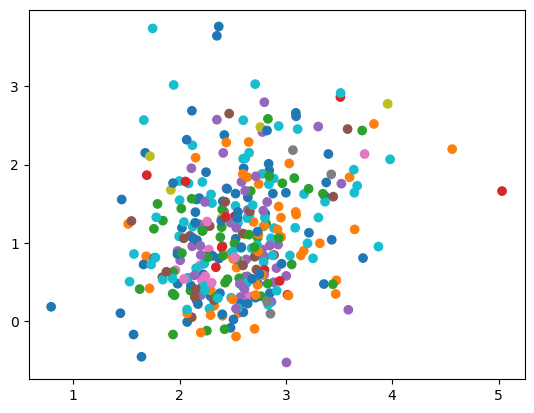

In [124]:
plot_latent(vae, train_loader1)

In [43]:
dev = qml.device("default.qubit", wires=4)

In [44]:
# QCNN layer
def qcnn_block(weights,wires):
    
    for w in range(wires):
        qml.Hadamard(w)
    
    # Convolution Layer 1
    qml.CNOT(wires=[0, 1])
    qml.RZ(weights[0], wires=1)
    qml.CNOT(wires=[2, 3])
    qml.RZ(weights[1], wires=3)
    #qml.CNOT(wires=[4, 5])
    #qml.RY(weights[3], wires=5)
    #qml.CNOT(wires=[6, 7])
    #qml.RY(weights[5], wires=7)
    #qml.CNOT(wires=[8, 9])
    #qml.RY(weights[7], wires=9)
    
    # Pooling Layer 1
    qml.CNOT(wires=[1, 0])
    qml.RY(weights[2], wires=0)  # keep 0, discard 1
    qml.CNOT(wires=[3, 2])
    qml.RY(weights[4], wires=2)  # keep 2, discard 3
    #qml.CNOT(wires=[5, 4])
    #qml.RY(weights[6], wires=4)  # keep 4, discard 5
    #qml.CNOT(wires=[7, 6])
    #qml.RY(weights[8], wires=6)  # keep 6, discard 7
    #qml.CNOT(wires=[9, 8])
    #qml.RY(weights[10], wires=8)  # keep 8, discard 9
    
    # Convolution Layer 2
    qml.CNOT(wires=[0, 2])
    qml.RZ(weights[6], wires=2)
    #qml.CNOT(wires=[2, 4])
    #qml.RY(weights[5], wires=4)
    #qml.CNOT(wires=[4, 6])
    #qml.RY(weights[4], wires=6)
    #qml.CNOT(wires=[6, 8])
    #qml.RY(weights[6], wires=8)

    """
    # Convolution Layer 3 (Final Layer)
    qml.CNOT(wires=[2, 0])
    qml.RY(weights[11], wires=0)
    qml.CNOT(wires=[6, 4])
    qml.RY(weights[12], wires=4)
    """

In [45]:
# Full QCNN circuit

@qml.qnode(dev, interface="torch")
def quantum_circuit(inputs, weights):
    # Angle encoding
    qml.templates.AngleEmbedding(inputs, wires=range(4), rotation='Y')
    qcnn_block(weights,wires=4)
    #print(qml.draw(qcnn_block)(weights))
    return [qml.expval(qml.PauliZ(i)) for i in [0,2]]

In [46]:
weight_shapes = {"weights": (8,)}
qcnn_layer = qml.qnn.TorchLayer(quantum_circuit, weight_shapes)


class QuantumLayer(nn.Module):
    def __init__(self):
        super().__init__()
        self.qlayer = qml.qnn.TorchLayer(quantum_circuit, weight_shapes)
        nn.init.uniform_(self.qlayer.qnode_weights["weights"], -0.1, 0.1)

    def forward(self, x):
        #return vmap(self.qlayer)(x)
        #outputs = [self.qlayer(sample) for sample in x]
        #return torch.stack(outputs)
        outputs = []
        for i, sample in enumerate(x):
            out = self.qlayer(sample)
            outputs.append(out)
        stacked = torch.stack(outputs)
        #print("  Inside QuantumLayer: input", x.shape, "output", stacked.shape)
        return stacked
"""
#QCNN MOdel Class
class QCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(110592, 4) 
        self.qcnn = QuantumLayer()
        #self.qcnn = qcnn_layer
        self.fc2 = nn.Linear(2, 8)       # Output layer for 8 classes

    def forward(self, x):
        x = x.view(x.size(0), -1 )
        x = torch.tanh(self.fc1(x))
        # Use vmap to apply the quantum layer to the batch
        x = self.qcnn(x) # [batch_size, 2]
        x = self.fc2(x)
        #return F.log_softmax(x, dim=1)
        return x
"""

'\n#QCNN MOdel Class\nclass QCNN(nn.Module):\n    def __init__(self):\n        super().__init__()\n        self.fc1 = nn.Linear(110592, 4) \n        self.qcnn = QuantumLayer()\n        #self.qcnn = qcnn_layer\n        self.fc2 = nn.Linear(2, 8)       # Output layer for 8 classes\n\n    def forward(self, x):\n        x = x.view(x.size(0), -1 )\n        x = torch.tanh(self.fc1(x))\n        # Use vmap to apply the quantum layer to the batch\n        x = self.qcnn(x) # [batch_size, 2]\n        x = self.fc2(x)\n        #return F.log_softmax(x, dim=1)\n        return x\n'

In [50]:
class HybridModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = VariationalEncoder()
        self.quantum = qcnn_layer
        self.decoder = Decoder()
        self.fc_out = nn.Linear(2, 8)  # Output logits for 10 MNIST classes

    
    def forward(self, x):
        latent = self.encoder(x)                      # Compress image to latent space
        quantum_out = self.quantum(latent)            # Quantum processing
        recons_image = self.decoder(quantum_out)      # reconstruction of image
        class_logits = self.fc_out(quantum_out)   # Final classification layer
                           
        return recons_image, F.log_softmax(class_logits, dim=1)

In [48]:

model = HybridModel() 
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

features, labels = features.to(device), labels.to(device)
outputs = model(features)


NameError: name 'features' is not defined

In [40]:
for features, labels in train_loader:
    print("Label sample:", labels)
    print("Label min:", labels.min().item(), "max:", labels.max().item())
    break

Label sample: tensor([6, 3, 2, 6, 7, 1, 2, 3])
Label min: 1 max: 7


In [51]:
import torch.nn as nn
import torch.optim as optim
import time
import numpy as np
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import precision_score, recall_score, f1_score

weights = 1.0 / counts
weights = weights * (np.sum(counts) / len(counts))

class_weights = torch.tensor(weights, dtype=torch.float32)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

class_weights = class_weights.to(device)
model = HybridModel().to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-3)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)


# History lists for plotting
train_loss_history = []
train_acc_history = []
test_loss_history = []
test_acc_history = []
test_f1_history = [] 

loss_bench = 0
n_epochs = 50

def qcnn_test(model, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    
    all_labels = []
    all_predictions = []
    
    with torch.no_grad():
        for features, labels in test_loader1:
            features, labels = features.to(device), labels.to(device)
            outputs = model(features)
            
            # Calculate and accumulate loss
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
            
        avg_loss = running_loss / len(test_loader1)
        accuracy = correct / len(test_loader1.dataset)
        
    # Calculate macro-averaged metrics
    # Note: Scikit-learn requires non-empty lists, which is guaranteed here
    macro_precision = precision_score(all_labels, all_predictions, average='macro', zero_division=0)
    macro_recall = recall_score(all_labels, all_predictions, average='macro', zero_division=0)
    macro_f1 = f1_score(all_labels, all_predictions, average='macro', zero_division=0)
    
    return avg_loss, accuracy, macro_precision, macro_recall, macro_f1

# --- Training Loop ---
for epoch in range(n_epochs):
    model.train()
    running_loss = 0.0
    total = 0
    correct = 0
    start_time = time.time()
    
    for features, labels in train_loader1:
        features, labels = features.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(features)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    end_time = time.time()
    
    # Calculate Training Metrics
    train_avg_loss = running_loss / len(train_loader1)
    train_accuracy = correct / total
    
    # Store Training History
    train_loss_history.append(train_avg_loss)
    train_acc_history.append(train_accuracy*100)
    
    # Evaluate on Test Set
    val_loss, val_accuracy, val_precision, val_recall, val_f1 = qcnn_test(model, criterion, device)

    scheduler.step(val_loss)
    
    # Store Test History
    test_loss_history.append(val_loss)
    test_acc_history.append(val_accuracy*100)
    test_f1_history.append(val_f1) # Example of tracking
    
    
    epoch_duration = end_time - start_time
    
    # Print Epoch Summary 
    print(f"Epoch {epoch+1:02d}: "
          f"Train Loss: {train_avg_loss:.4f}, Train Acc: {train_accuracy:.4f} | "
          f"Test Loss: {val_loss:.4f}, Test Acc: {val_accuracy:.4f} | "
          f"Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1: {val_f1:.4f} | "
          f"Time: {epoch_duration:.2f}s")

ValueError: Features must be of length 4 or less; got length 8.

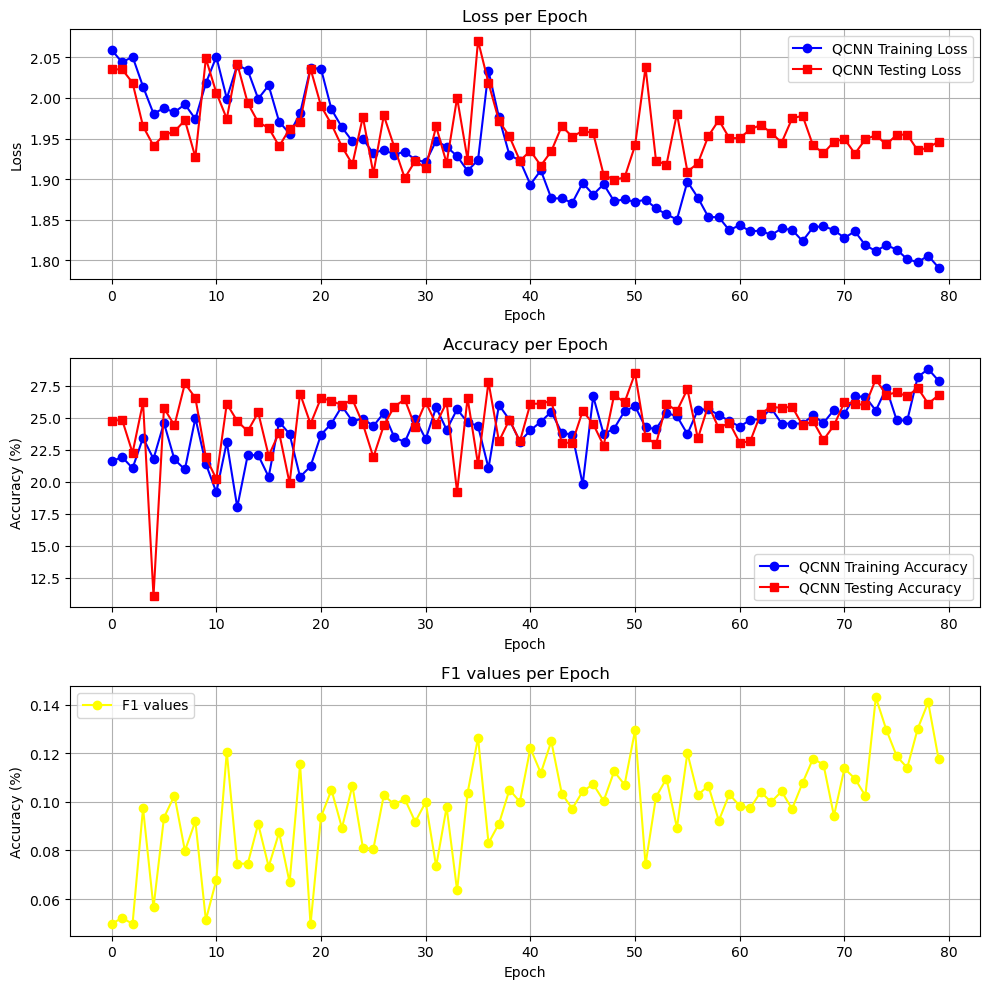

In [34]:

import matplotlib.pyplot as plt
# Plot training loss
plt.figure(figsize=(10, 10))

plt.subplot(3, 1,1)
plt.plot(train_loss_history, marker='o', label='QCNN Training Loss', color='blue')
plt.plot(test_loss_history,marker='s', label='QCNN Testing Loss', color='red')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

# Plot test accuracy
plt.subplot(3, 1, 2)
plt.plot(train_acc_history, marker= 'o', label='QCNN Training Accuracy', color= 'blue')
plt.plot(test_acc_history,marker= 's', label= 'QCNN Testing Accuracy', color= 'red')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.grid(True)
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(test_f1_history, marker= 'o', label='F1 values', color= 'yellow')
#plt.plot(test_acc_history,marker= 's', label= 'QCNN Testing Accuracy', color= 'red')
plt.title('F1 values per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.grid(True)
plt.legend()


plt.tight_layout()
#plt.savefig('protein_qcnn.png')
plt.show()

In [47]:
# Save the current model state dictionary
torch.save(model.state_dict(), 'final_2d_cnn_best_epoch_30.pth')
model.load_state_dict(torch.load('final_2d_cnn_best_epoch_30.pth', map_location=device))
model.eval()

QCNN(
  (fc1): Linear(in_features=16384, out_features=4, bias=True)
  (qcnn): QuantumLayer(
    (qlayer): <Quantum Torch Layer: func=quantum_circuit>
  )
  (fc2): Linear(in_features=2, out_features=8, bias=True)
)

In [48]:
# Select a random sample from the filtered DataFrame
random_sample = parsed_df.sample(n=1).iloc[0]

# 1. Extract the data and true label
# Assuming 'coords' is the column containing the array of C-alpha coordinates
# and 'mapped_class' is the re-indexed label (0-7)
protein_coords = random_sample['ca_coords']
true_label_index = random_sample['main_class']
protein_id = random_sample['pdb_id'] # Use a relevant ID column for tracking

# 2. Generate the Distance Map (assuming you have this function available)
# The output should be 128x128 or whatever size your model expects
distance_map = calculate_distance_matrix(protein_coords)

# 3. Add Channel and Batch Dimensions for PyTorch (1, 1, 128, 128)
# Ensure the data type is float32
input_tensor = torch.tensor(distance_map, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)

print(f"--- Testing Protein: {protein_id} ---")
print(f"True Class Index (Mapped): {true_label_index}")

--- Testing Protein: 1JDP ---
True Class Index (Mapped): c


In [49]:
specific_protein_row = parsed_df[parsed_df['pdb_id'] == '1JDP']
print(specific_protein_row)

     pdb_id chain   fold_id   domain main_class  n_residues  \
2530   1JDP     A  c.93.1.1  d1jdpa_          c         396   

                                                res_ids  \
2530  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   

                                              ca_coords  fold_label  
2530  [[48.249, -24.101, 27.808], [44.576, -23.518, ...           2  
